In [1]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

import copy
import pickle
import numpy as np
from time import time
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import distributed as dist
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

from syn_src.utils import *
from syn_src.data_generator import *
from syn_src.classifier import Classifier
from syn_src.gan import Generator, Discriminator, DistributionDiscriminator
from syn_src.train_classifier import risk_minimization, valid_classifier
from syn_src.train_gan import train_gan, generate_dataset_from_gan


np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



# 1. Parameters

In [2]:
# 文件保存
experiment = 1

# 生成数据集
no = 10000
x_dim = 6
seq_len = 10
hiddens = [x_dim + 1, 32, 64, 1]
epsilon = 0.1

# 数据预处理
test_size = 0.2
valid_size = 0.125
batch_size = 512

# Step1: 训练Classifier
c_hiddens = [x_dim + 1, 32, 64, 1]

# Step2: 训练GAN
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 7000

# Step3: 重训练Classifier
w_lambda = 128.4
f_lambda = 2.1

# 使用CPU或GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 1.1 Save Files

In [3]:
res_path = Path('../results')
log_dir = res_path / f'experiment_{experiment}'
true_path = log_dir / (f"true_model" + ".pth")
clf_path = log_dir / (f"c_model" + ".pth")
gan_path = log_dir / (f"gan_model_" + str(gan_epochs) + "_" + str(g_hidden_size) + ".pth")
re_clf_path = log_dir / (f"rc_model-" + str(w_lambda) + "_" + str(f_lambda) + ".pth")
tsne_path = log_dir / (f"syn-tsne.png")
dist_path = log_dir / (f"syn-deeplf-9-step.png")

if not res_path.exists():
    res_path.mkdir()

if not log_dir.exists():
    log_dir.mkdir(parents=True)

# 2. Generate Synthetic Dataset

In [4]:
s0, x, y, true_model = generate_sequential_datasets(no, x_dim, seq_len, hiddens, epsilon, device, true_path)
true_model.to(device)

Time:  5.08s


TrueModel(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_fn): BCELoss()
)

### 2.1 Processing Datasets

In [5]:
# 划分训练集和测试集
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(s_train.shape, x_train.shape, y_train.shape)

# 把数据标准化到[0, 1]区间
scalers = [MinMaxScaler() for _ in range(seq_len)]
for i in range(seq_len):
    x_train[:, i] = scalers[i].fit_transform(x_train[:, i])
    x_valid[:, i] = scalers[i].transform(x_valid[:, i])
    x_test[:, i] = scalers[i].transform(x_test[:, i])

# 生成数据生成器
train_data = TensorDataset(tensor(s_train), tensor(x_train), tensor(y_train))
valid_data = TensorDataset(tensor(s_valid), tensor(x_valid),tensor(y_valid))
test_data = TensorDataset(tensor(s_test), tensor(x_test), tensor(y_test))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

(7000, 1) (7000, 10, 6) (7000, 10, 1)


# 2. Train Classifier

In [6]:
clf = Classifier(c_hiddens)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [7]:
if not clf_path.exists():
    clf.fit(train_loader, valid_loader, clf_path, device)
clf.load_state_dict(torch.load(clf_path, map_location=device))
clf.eval(test_loader, device)

13.907402217388153

# 3. Train Seq-GAN

In [8]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)

Generator(
  (h0_linear): Linear(in_features=6, out_features=64, bias=True)
  (rnn): GRU(9, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)

Discriminator(
  (rnn): GRU(6, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, clf, generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

### 3.1 Genearte Datasets from GAN

In [11]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, clf, generator, device)

In [12]:
clf.eval(gen_test_loader, device)

7.25940166413784

### 3.2 Visualization

Real shape: (250, 10, 6)
Syn shape: (250, 10, 6)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.073169
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.189445
[t-SNE] KL divergence after 1000 iterations: 1.044493


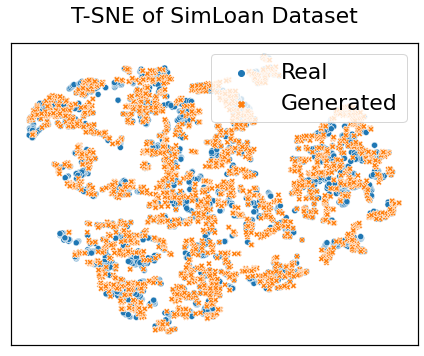

In [13]:
visualization(x_test, gen_test_x[:, 0:10], tsne_path)

# 4. Retrain Classifier

In [14]:
true_model = copy.deepcopy(clf)
re_clf = copy.deepcopy(clf)

In [15]:
risk_minimization(batch_size, seq_len, true_model, re_clf, generator, gen_train_loader, w_lambda, f_lambda, device, re_clf_path)
re_clf.load_state_dict(torch.load(re_clf_path, map_location=device))
valid_classifier(seq_len, true_model, re_clf, generator, gen_valid_loader, device, verbose=False)

Time: 241.34s


(-0.027848094701766968, -0.052787948530180984)

In [16]:
valid_classifier(seq_len, true_model, re_clf, generator, gen_test_loader, device)

Step:     0, ACC:70.650%, Short-Fair:-0.166, Long-Fair:-0.306, W-dist:0.3125
Step:     1, ACC:77.500%, Short-Fair:-0.081, Long-Fair:-0.147, W-dist:0.2915
Step:     2, ACC:80.350%, Short-Fair:-0.050, Long-Fair:-0.202, W-dist:0.2732
Step:     3, ACC:82.400%, Short-Fair:-0.081, Long-Fair:-0.088, W-dist:0.2514
Step:     4, ACC:84.500%, Short-Fair:-0.024, Long-Fair:-0.062, W-dist:0.2492
Step:     5, ACC:83.900%, Short-Fair: 0.008, Long-Fair:-0.041, W-dist:0.2509
Step:     6, ACC:84.500%, Short-Fair:-0.004, Long-Fair:-0.039, W-dist:0.2524
Step:     7, ACC:85.900%, Short-Fair:-0.023, Long-Fair:-0.023, W-dist:0.2483
Step:     8, ACC:86.250%, Short-Fair: 0.007, Long-Fair:-0.021, W-dist:0.2380
Step:     9, ACC:86.300%, Short-Fair: 0.001, Long-Fair:-0.006, W-dist:0.2368


(0.0013495087623596191, -0.00645286461096839)

In [17]:
valid_classifier(seq_len, true_model, re_clf, generator, gen_test_loader, device, idx=9)

Step:     0, ACC:88.300%, Short-Fair:-0.003, Long-Fair: 0.113, W-dist:0.2998
Step:     1, ACC:89.350%, Short-Fair: 0.013, Long-Fair:-0.083, W-dist:0.2583
Step:     2, ACC:88.950%, Short-Fair: 0.015, Long-Fair:-0.052, W-dist:0.2559
Step:     3, ACC:89.300%, Short-Fair: 0.001, Long-Fair: 0.015, W-dist:0.2425
Step:     4, ACC:89.450%, Short-Fair:-0.026, Long-Fair: 0.057, W-dist:0.2393
Step:     5, ACC:89.850%, Short-Fair:-0.028, Long-Fair: 0.049, W-dist:0.2411
Step:     6, ACC:89.050%, Short-Fair:-0.045, Long-Fair: 0.052, W-dist:0.2441
Step:     7, ACC:89.450%, Short-Fair:-0.042, Long-Fair: 0.069, W-dist:0.2469
Step:     8, ACC:91.300%, Short-Fair:-0.018, Long-Fair: 0.072, W-dist:0.2345
Step:     9, ACC:89.600%, Short-Fair:-0.026, Long-Fair: 0.050, W-dist:0.2367


(-0.025641024112701416, 0.049766378431568004)

#### 4.1 Visualization

In [18]:
gen_train_loader1, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, re_clf, generator, device)
gen_valid_loader1, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, re_clf, generator, device)
gen_test_loader1, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, re_clf, generator, device)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.090122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.730186
[t-SNE] KL divergence after 1000 iterations: 1.027842


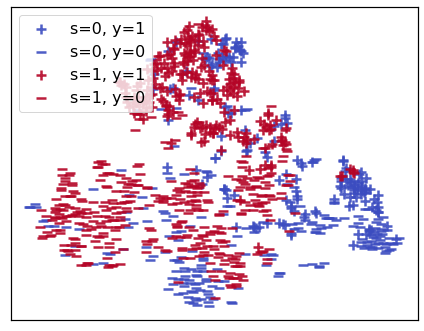

In [19]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=-1, path=dist_path)